In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

from yellowbrick.classifier import confusion_matrix, class_prediction_error

## ***0 Описание задачи***

Определение качества вина с помощью анализа физико-химических свойств.

## ***1 Загрузка датасета***

Датасет представлен в виде двух csv файлах. Каждый из них соответствует красному и белому вину. Объединим эти два csv файла в один. Для этого добавим в каждый из csv файлов столбец "тип вина" и затем объединим их.

In [ ]:
def load_dataframe():
    url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

    data_raw_red = pd.read_csv(url_red, sep = ";")
    data_raw_white = pd.read_csv(url_white, sep = ";")

    data_raw_red['type'] = "red"
    data_raw_white["type"] = "white"

    data_set = pd.concat([data_raw_red, data_raw_white], ignore_index=True)
    return data_set

In [ ]:
df = load_dataframe()

Рассмотрим признаки в датасете:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [ ]:
df["quality"].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

Признак "quality" является оценкой в диапазоне от 1 до 10.
Введем новый признак тип качества:

* 0 (плохое) (quality 1-4)
* 1 (обычное) (quality 5-7)
* 2(хорошее) (quality 8-10)

In [ ]:
test_conditions = [df["quality"]<=4, df["quality"] <=7, df["quality"]>=8]
test_choices = [0, 1, 2]
df["type_quality"] = np.select(test_conditions, test_choices)
df = df.drop(columns = "quality");

In [ ]:
df["type_quality"]

0       1
1       1
2       1
3       1
4       1
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: type_quality, Length: 6497, dtype: int32

Опишем каждый из признаков:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type                  6497 non-null   object 
 12  type_quality          6497 non-null   int32  
dtypes: float64(11), int32(1), object(1)
memory usage: 634.6+ KB


0. fixed acidity - фиксированная кислотность - числовой
1. volatile acidity - летучая кислотность - числовой
2. citric acid - лимонная кислота - числовой
3. residual sugar - остаточный сахар - числовой
4. chlorides - хлориды - числовой
5. free sulfur dioxide - свободный диоксид серы - числовой
6. total sulfur dioxide - общий диоксид серы - числовой
7. density - плотность - числовой
8. pH - водородный показатель - числовой
9. sulphates - сульфаты - числовой
10. alcohol - содержание алкоголя - числовой
11. quality - качество вина (оценка от 0 до 10) - числовой (удален)
12. type - тип вина (белое или красное) - категориальный (red, white)
13. type_quality - качество вина (оценка от 0 до 2) - числовой *Курсив*

## ***2 Визуализация данных. Вычисление основных характеристик***

Вычислим основные характеристики:

In [ ]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  type_quality  
count  6497.000000  6497.000000  6497.000000   6497.000000  
mean      3.218501     0.531268    10.491801      0.992612  
std       0.160787     0.148806     1.192712      0.261333  
min       2.720000     0.220000     8.000000      0.000000  
25%       3.110000     0.430000     9.500000      1.000000  
50%       3.210000     0.510000    10.300000      1.000000  
75%       3.320000     0.600000    11.300000      1.000000  
max       4.010000     2.000000    14.900000      2.000000

Построим диаграммы для таких признаков как тип вина и его качество

Text(0, 0.5, 'Количество')

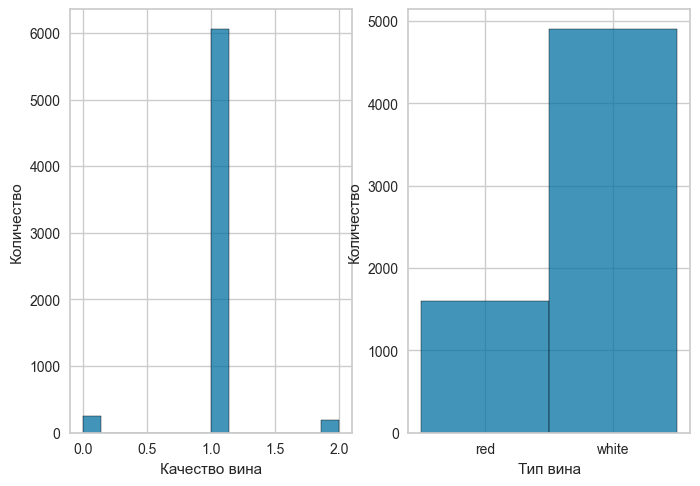

In [ ]:
fig,axes = plt.subplots(1,2)
sns.histplot(data=df, x="type_quality", ax=axes[0])
axes[0].set_xlabel("Качество вина")
axes[0].set_ylabel("Количество")
sns.histplot(data=df, x="type", ax=axes[1])
axes[1].set_xlabel("Тип вина")
axes[1].set_ylabel("Количество")

Из диаграмм можно сделать вывод о том, что большинство вин являются белыми и распространены "обычные"

Рассмотрим зависимость качества и типа вина от фиксированной кислотности:

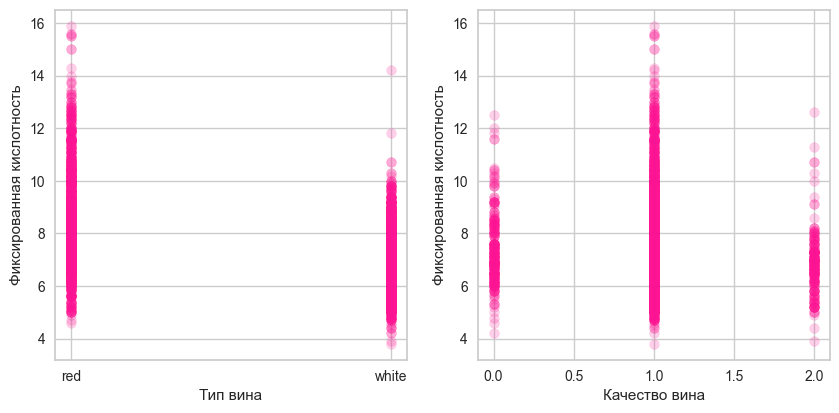

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)

ax_1.scatter(df['type'], df['fixed acidity'],
            alpha=0.2, color = "deeppink")
ax_1.set_xlabel('Тип вина')
ax_1.set_ylabel('Фиксированная кислотность');

ax_2.scatter(df['type_quality'], df['fixed acidity'],
            alpha=0.2, color = "deeppink")
ax_2.set_xlabel('Качество вина')
ax_2.set_ylabel('Фиксированная кислотность');

Из диаграмм можно сделать вывод о том, что большая часть хорошего вина имеет кислотность от 5 до 8, а кислотность вина среднего качества может быть любой. Также, что красное вино имеет высокую кислотность.

Теперь рассмотрим зависимость качества от плотности

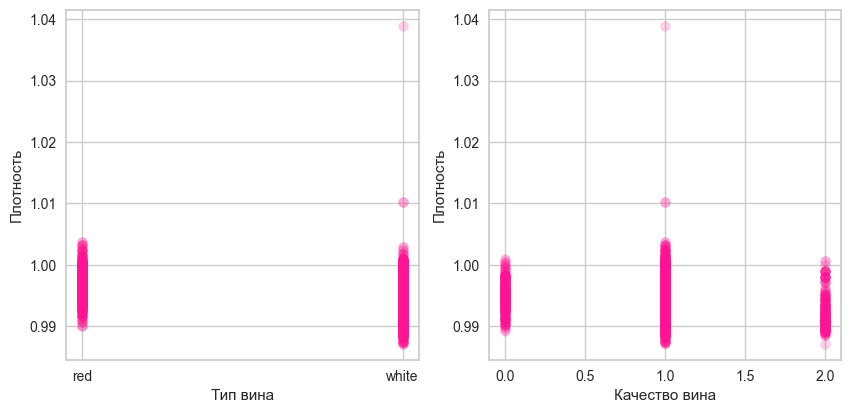

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)

ax_1.scatter(df['type'], df['density'],
            alpha=0.2, color = "deeppink")
ax_1.set_xlabel('Тип вина')
ax_1.set_ylabel('Плотность');

ax_2.scatter(df['type_quality'], df['density'],
            alpha=0.2, color = "deeppink")
ax_2.set_xlabel('Качество вина')
ax_2.set_ylabel('Плотность');

Исходя из диаграмм можем сделать вывод о том, что вино в среднем имеет одинаковую плотность. Также можно заметить несколько незначительных "выбросов"

Построим диаграммы рассеивания

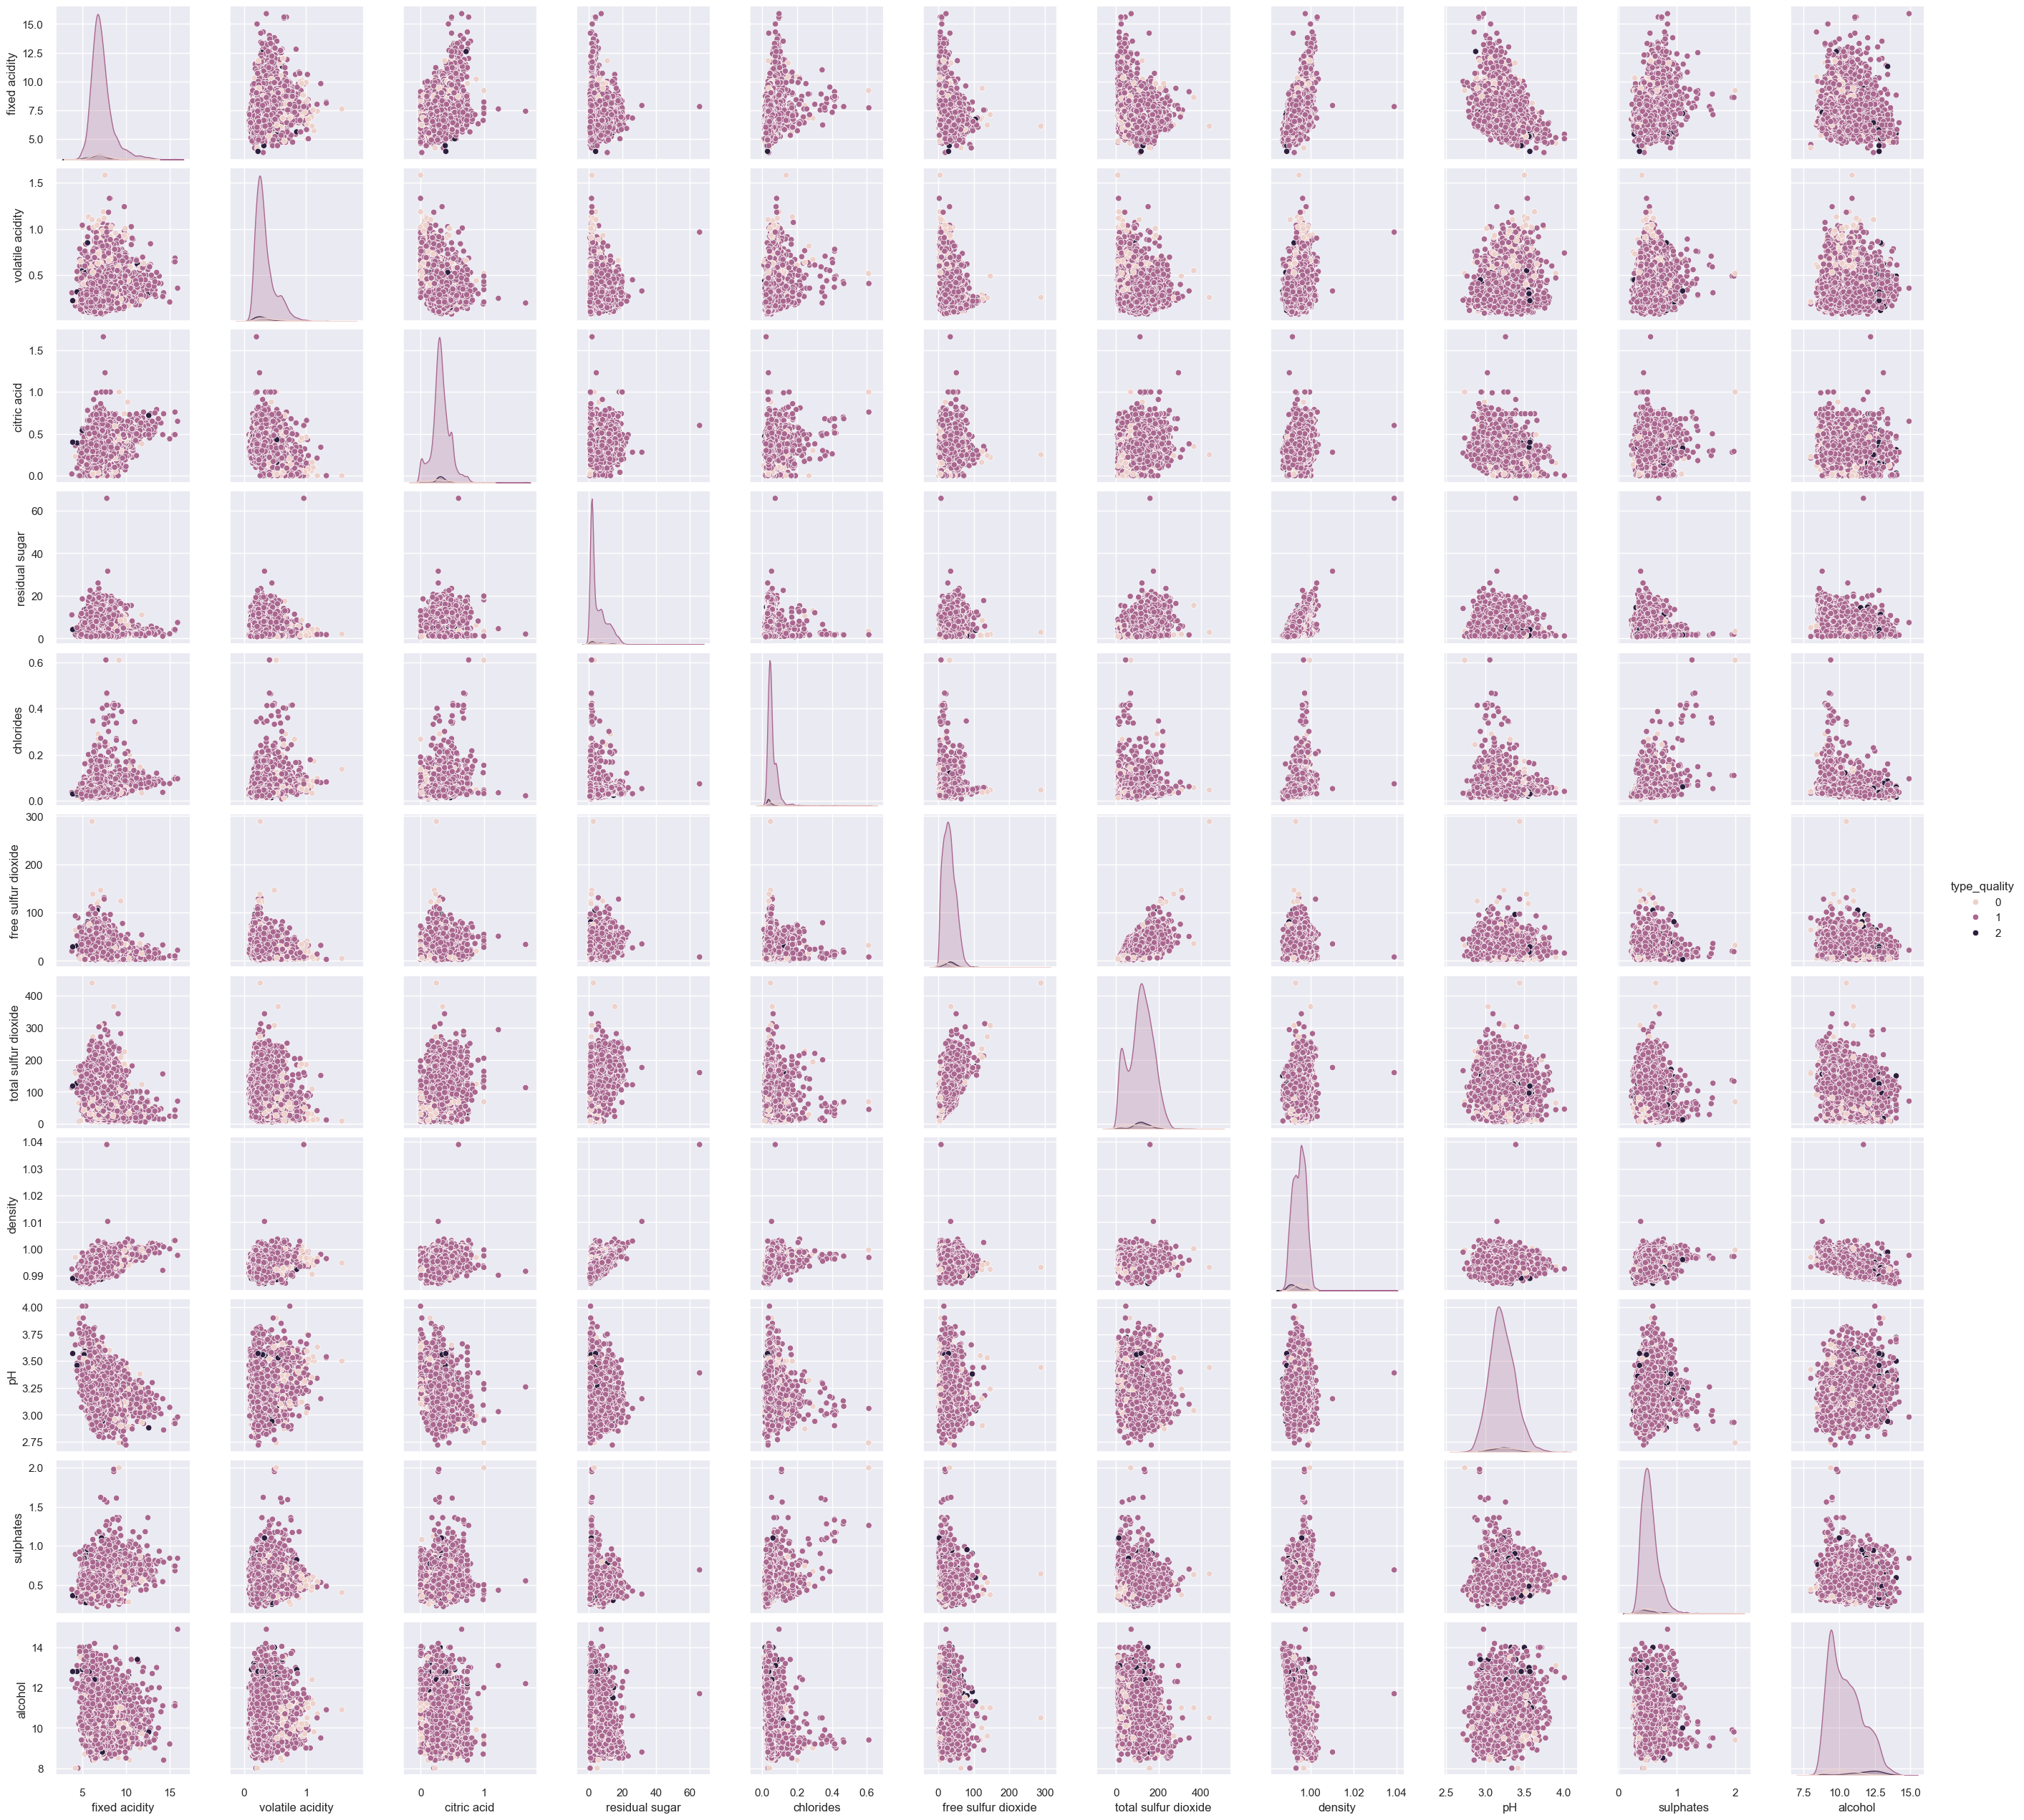

In [ ]:
sns.set(font_scale=1.0)
cols = df.columns
g = sns.pairplot(data = df.loc[:, cols], hue='type_quality')
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)

Построим матрицу корреляции

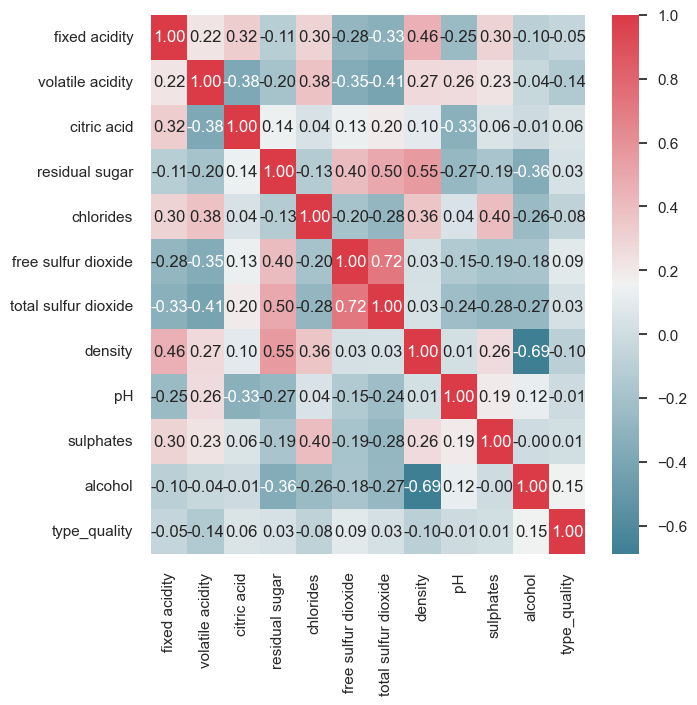

In [ ]:
corr_mat = df.drop(columns = "type").corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")
sns.set(font_scale=1.0)

Выведем признаки, для которых коэффициенты корреляции > 0.5, для остальных признаков можно сказать, что связь между ними слабая:

In [ ]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

free sulfur dioxide  total sulfur dioxide    0.720934
residual sugar       density                 0.552517
dtype: float64

Корреляции объяснимы следующим:


*   свободный диоксид серы входит в общий диоксид серы
*   тип качества это производная от качества
*   сахар является плотным следовательно повышается общая плотность вина

 ## ***3 Обработка пропущенных значений***

In [ ]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
type_quality            0
dtype: int64

## 4. ***Обработка категориальных признаков***

Тип вина является object. Приведем его к бинарному

In [ ]:
df['type'] = pd.factorize(df['type'])[0]

## 4. ***Нормализация***

In [ ]:
df_norm = (df - df.mean(axis = 0))/df.std(axis = 0)

In [ ]:
df_norm.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   6.497000e+03      6.497000e+03  6.497000e+03    6.497000e+03   
mean   -4.549573e-16      1.049902e-16  2.624754e-17    5.249508e-17   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.634386e+00     -1.577208e+00 -2.192664e+00   -1.017956e+00   
25%    -6.288845e-01     -6.661100e-01 -4.722972e-01   -7.657389e-01   
50%    -1.660764e-01     -3.016707e-01 -5.940918e-02   -5.135217e-01   
75%     3.738663e-01      3.664680e-01  4.911081e-01    5.584015e-01   
max     6.698910e+00      7.533774e+00  9.230570e+00    1.268585e+01   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  6.497000e+03         6.497000e+03           6497.000000  6.497000e+03   
mean   1.749836e-17        -1.049902e-16              0.000000 -3.552167e-15   
std    1.000000e+00         1.000000e+00              1.000000  1.000000e+00   
min   -1.342536e+00        -1.663455e+00             -1.941631 -2.529997e+00   
25%   -5.147590e-01        -7.620156e-01             -0.685480 -7.858922e-01   
50%   -2.578628e-01        -8.593639e-02              0.039904  6.448391e-02   
75%    2.559297e-01         5.901428e-01              0.712210  7.647937e-01   
max    1.584097e+01         1.456245e+01              5.736815  1.476765e+01   

                 pH     sulphates       alcohol          type  type_quality  
count  6.497000e+03  6.497000e+03  6.497000e+03  6.497000e+03  6.497000e+03  
mean   2.729744e-15 -4.899540e-16  9.799081e-16 -6.999344e-17 -1.334250e-16  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
min   -3.100376e+00 -2.091774e+00 -2.089189e+00 -1.750055e+00 -3.798259e+00  
25%   -6.748102e-01 -6.805395e-01 -8.315512e-01  5.713226e-01  2.827049e-02  
50%   -5.287017e-02 -1.429263e-01 -1.608107e-01  5.713226e-01  2.827049e-02  
75%    6.312639e-01  4.618885e-01  6.776148e-01  5.713226e-01  2.827049e-02  
max    4.922650e+00  9.870119e+00  3.695947e+00  5.713226e-01  3.854800e+00

## 5. ***Разделение на обучающую и тестовую выборки***

В самом начале мы соединяли два csv файла в один. Следовательно типы вина у нас идут по порядку. Перемешаем строки в датасете, чтобы это исправить

In [ ]:
df_norm = df_norm.sample(frac=1).reset_index(drop=True)

Используем все признаки, кроме free sulfur dioxide и residual sugar (поскольку они корреляционны с total sulfur dioxide и density):

In [ ]:
X = np.array(df_norm.drop(["free sulfur dioxide", "residual sugar", "type_quality"], axis=1))
Y = np.array(df['type_quality'])

Разделим данные. На обучающую выборку отводится 15%, 85% - на тестовую

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 63)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

classes = [0, 1, 2]

N_train, N_test

(5522, 975)

## ***6 KNN***

Запустим для 4 соседей

In [ ]:
LR = KNeighborsClassifier(n_neighbors = 4)
LR.fit(X_train, Y_train)

LR_training_predict = LR.score(X_train, Y_train)
LR_test_predict = LR.score(X_test, Y_test)

err_train = np.mean(Y_train != LR.predict(X_train))
err_test  = np.mean(Y_test  != LR.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(LR_training_predict, LR_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.93, Test: 0.92. 
Error. Train : 0.07, Test: 0.08. 


Построим матрицу ошибок

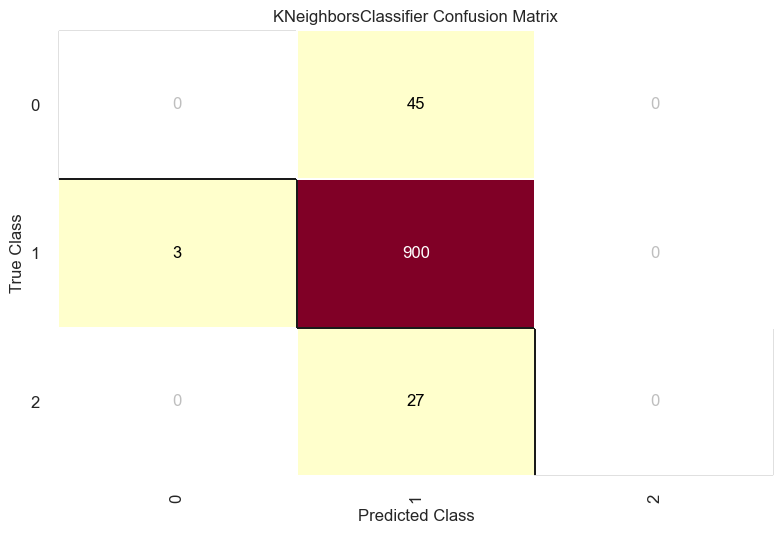

ConfusionMatrix(ax=<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=[0, 1, 2],
                cmap=<matplotlib.colors.ListedColormap object at 0x000002321F6BC5C0>,
                estimator=KNeighborsClassifier(n_neighbors=4))

In [ ]:
confusion_matrix(LR, X_train, Y_train, X_test, Y_test, classes=classes)

Запустим на 16 соседях и также построим матрицу ошибок

In [ ]:
LR = KNeighborsClassifier(n_neighbors = 16)
LR.fit(X_train, Y_train)

LR_training_predict = LR.score(X_train, Y_train)
LR_test_predict = LR.score(X_test, Y_test)

err_train = np.mean(Y_train != LR.predict(X_train))
err_test  = np.mean(Y_test  != LR.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(LR_training_predict, LR_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.93, Test: 0.93. 
Error. Train : 0.07, Test: 0.07. 


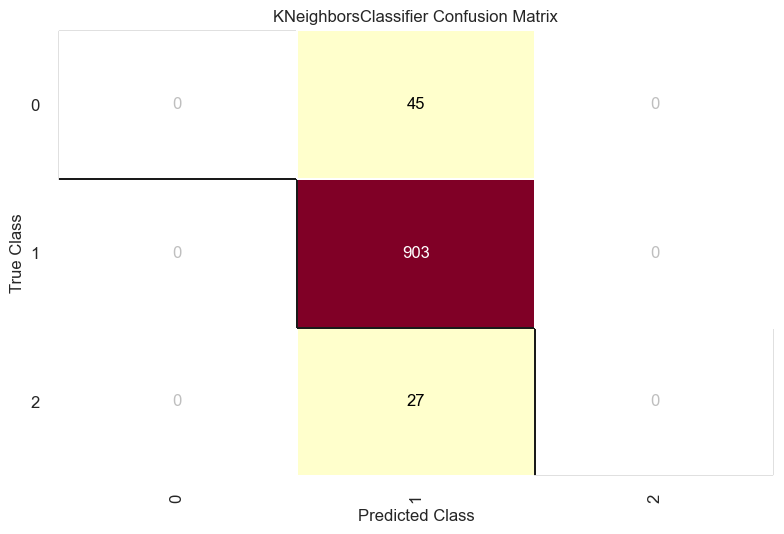

ConfusionMatrix(ax=<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=[0, 1, 2],
                cmap=<matplotlib.colors.ListedColormap object at 0x000002321F6BD460>,
                estimator=KNeighborsClassifier(n_neighbors=16))

In [ ]:
confusion_matrix(LR, X_train, Y_train, X_test, Y_test, classes=classes)

Запустим для разного количества соседей от 1 до 50, чтобы найти оптимальное число

In [ ]:
def KNeighbors_grid(range_):
    test_err = []
    train_err = []
    train_acc = []
    test_acc = []

    for neigh in range_:
        mlp_model = KNeighborsClassifier(n_neighbors = neigh)
        mlp_model.fit(X_train, Y_train)

        y_train_pred = mlp_model.predict(X_train)
        y_test_pred = mlp_model.predict(X_test)

        train_err.append(np.mean(Y_train != y_train_pred))
        test_err.append(np.mean(Y_test != y_test_pred))

        train_acc.append(accuracy_score(Y_train, y_train_pred))
        test_acc.append(accuracy_score(Y_test, y_test_pred))

    return test_err, train_err, train_acc, test_acc

In [ ]:
keighs = np.arange(1, 50, 1)
test_err, train_err, train_acc, test_acc = KNeighbors_grid(keighs)

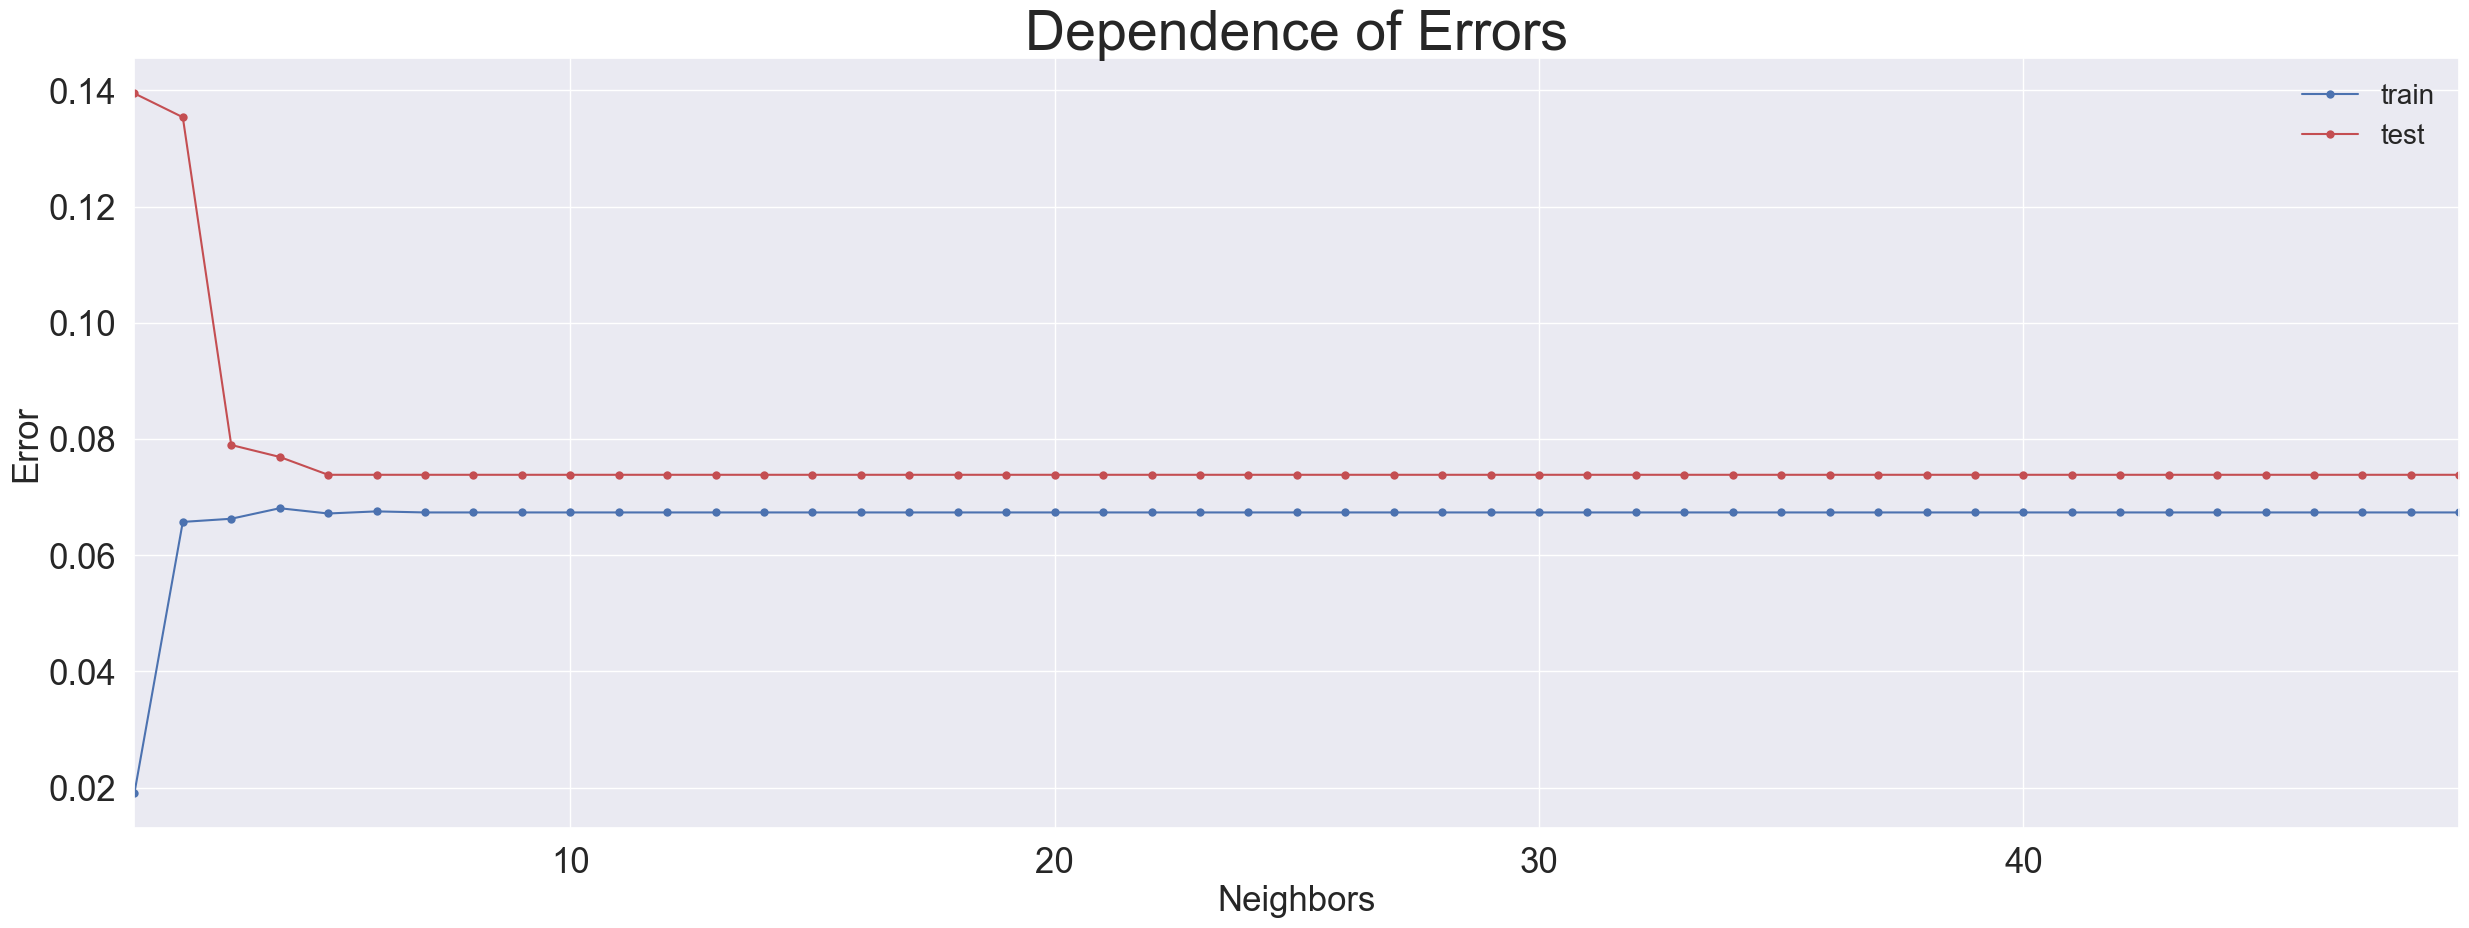

In [ ]:
plt.figure(figsize = (30, 10))

plt.plot(keighs, train_err, 'b-o', label = 'train')
plt.plot(keighs, test_err, 'r-o', label = 'test')

plt.xlim([np.min(keighs), np.max(keighs)])

plt.title('Dependence of Errors', fontsize = 40)
plt.xlabel('Neighbors', fontsize = 25)
plt.ylabel('Error', fontsize = 25)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)

plt.legend(fontsize = 20)

## ***6 Logistic Regression***


In [ ]:
LR = LogisticRegression(max_iter=500)
LR.fit(X_train, Y_train)

LR_training_predict = LR.score(X_train, Y_train)
LR_test_predict = LR.score(X_test, Y_test)

err_train = np.mean(Y_train != LR.predict(X_train))
err_test  = np.mean(Y_test  != LR.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(LR_training_predict, LR_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.93, Test: 0.93. 
Error. Train : 0.07, Test: 0.07. 


## ***7 RandomForest***




In [ ]:
RanForest = RandomForestClassifier(n_estimators = 100)
RanForest.fit(X_train, Y_train)

RanForest_training_predict = RanForest.score(X_train, Y_train)
RanForest_test_predict = RanForest.score(X_test, Y_test)

err_train = np.mean(Y_train != RanForest.predict(X_train))
err_test  = np.mean(Y_test  != RanForest.predict(X_test))

print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(RanForest_training_predict, RanForest_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.98, Test: 0.90. 
Error. Train : 0.02, Test: 0.10. 


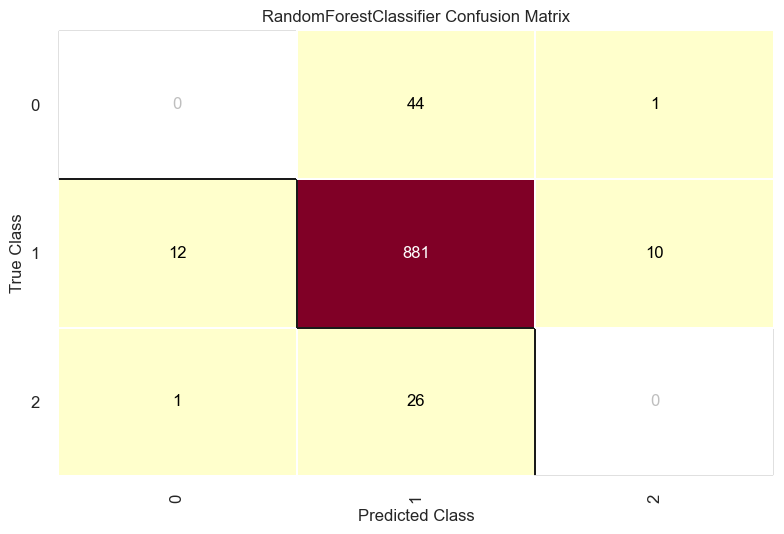

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=[0, 1, 2],
                cmap=<matplotlib.colors.ListedColormap object at 0x0000023228E6F830>,
                estimator=RandomForestClassifier())

In [ ]:
confusion_matrix(RanForest, X_train, Y_train, X_test, Y_test, classes=classes)

In [ ]:
def RF_grid(range_):
    test_err = []
    train_err = []
    train_acc = []
    test_acc = []

    for maxdepth in range_:
        mlp_model = RandomForestClassifier(n_estimators = 100, max_depth = maxdepth)
        mlp_model.fit(X_train, Y_train)

        y_train_pred = mlp_model.predict(X_train)
        y_test_pred = mlp_model.predict(X_test)

        train_err.append(np.mean(Y_train != y_train_pred))
        test_err.append(np.mean(Y_test != y_test_pred))

        train_acc.append(accuracy_score(Y_train, y_train_pred))
        test_acc.append(accuracy_score(Y_test, y_test_pred))
    return  test_err, train_err, train_acc, test_acc

In [ ]:
maxdepths = np.arange(1, 100, 1)
test_err, train_err, train_acc, test_acc = RF_grid(maxdepths)

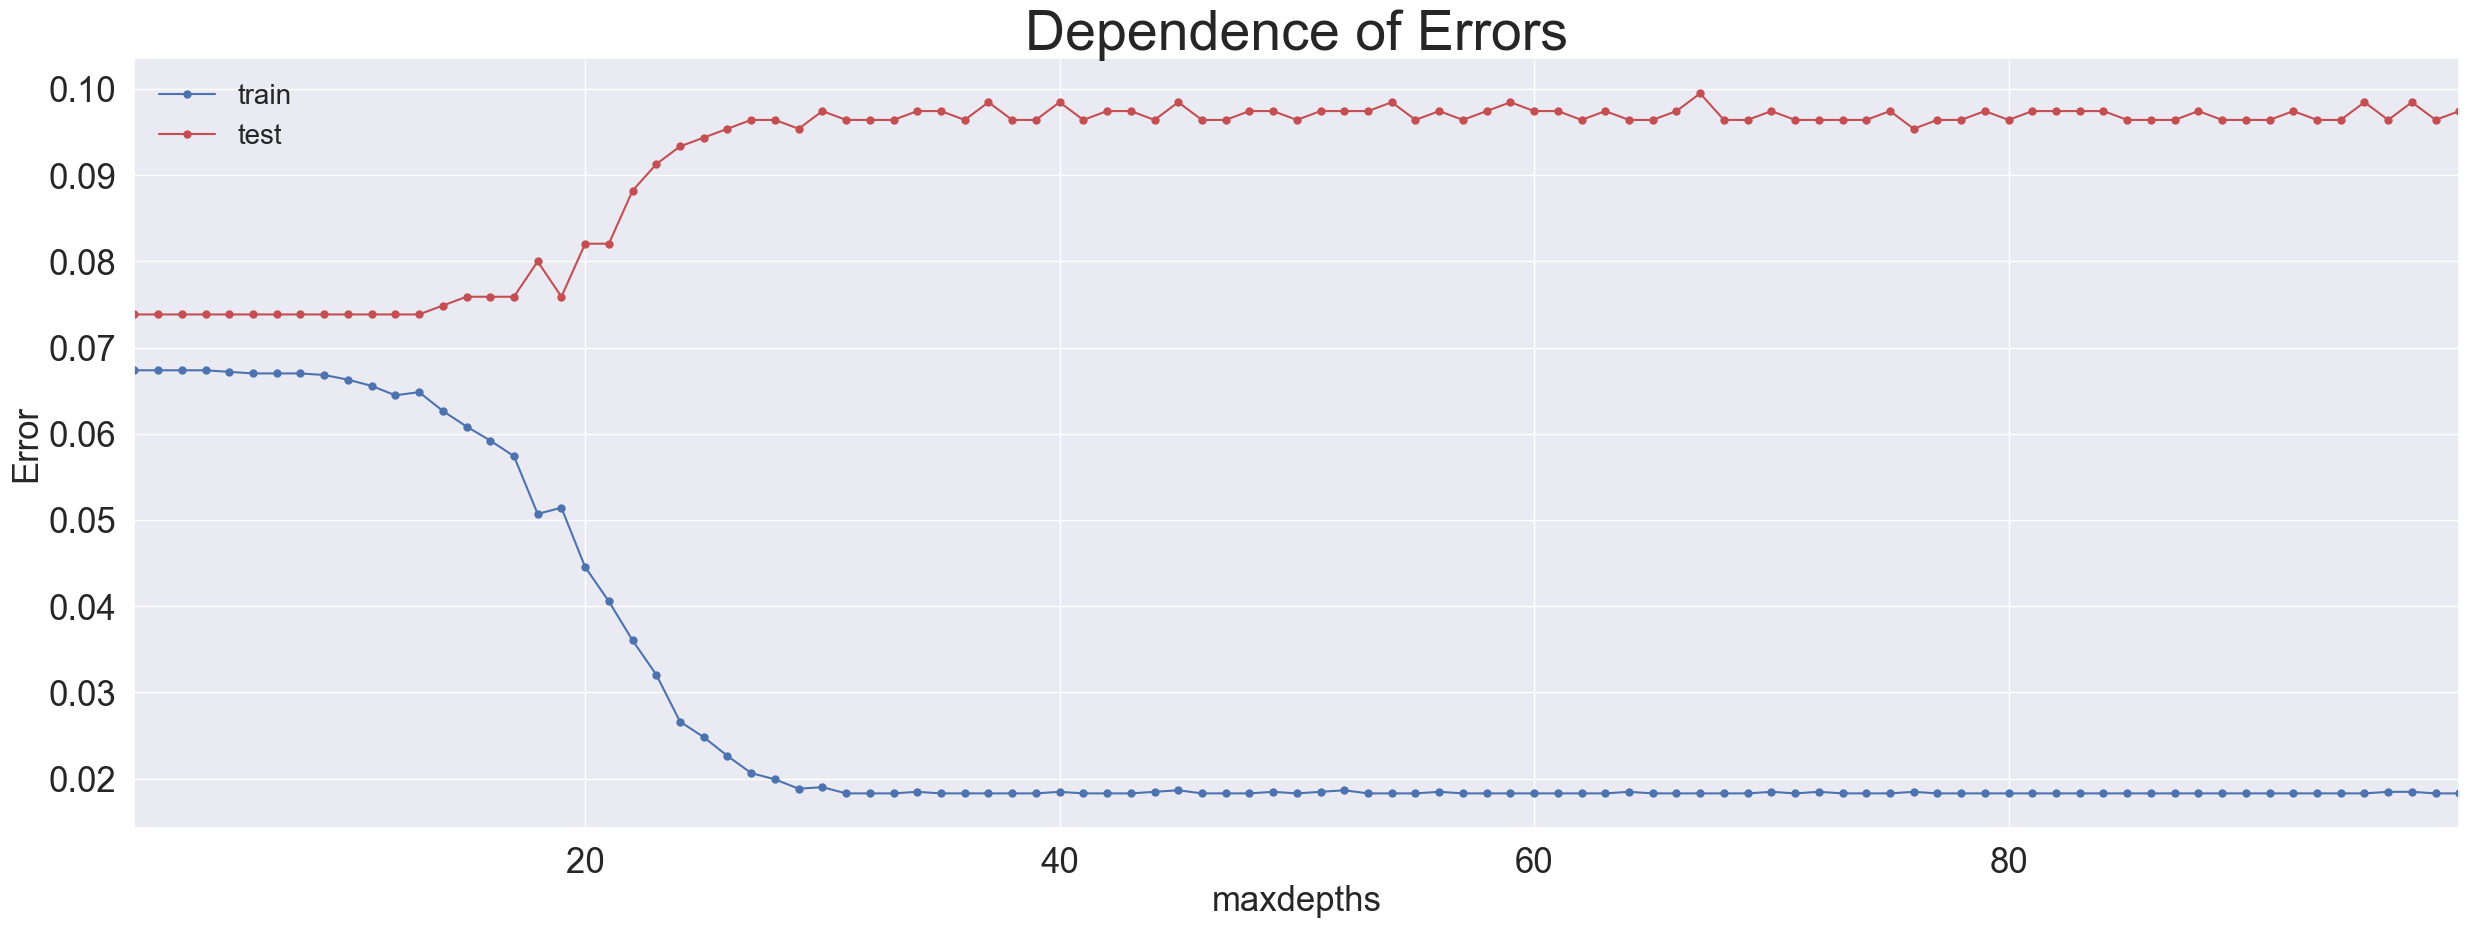

In [ ]:
plt.figure(figsize = (30, 10))

plt.plot(maxdepths, train_err, 'b-o', label = 'train')
plt.plot(maxdepths, test_err, 'r-o', label = 'test')

plt.xlim([np.min(maxdepths), np.max(maxdepths)])

plt.title('Dependence of Errors', fontsize = 40)
plt.xlabel('maxdepths', fontsize = 25)
plt.ylabel('Error', fontsize = 25)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)

plt.legend(fontsize = 20)

## ***Network***

In [ ]:
NN = MLPClassifier(hidden_layer_sizes=(50), max_iter=500, alpha = 0.0001)
NN.fit(X_train, Y_train)

#score
NN_training_predict = NN.score(X_train, Y_train)
NN_test_predict = NN.score(X_test, Y_test)

# error
err_train = np.mean(Y_train != NN.predict(X_train))
err_test  = np.mean(Y_test  != NN.predict(X_test))

# print
print("Accuracy. Train : {:.2f}, Test: {:.2f}. ".format(NN_training_predict, NN_test_predict))
print("Error. Train : {:.2f}, Test: {:.2f}. ".format(err_train, err_test))

Accuracy. Train : 0.93, Test: 0.93. 
Error. Train : 0.07, Test: 0.07. 


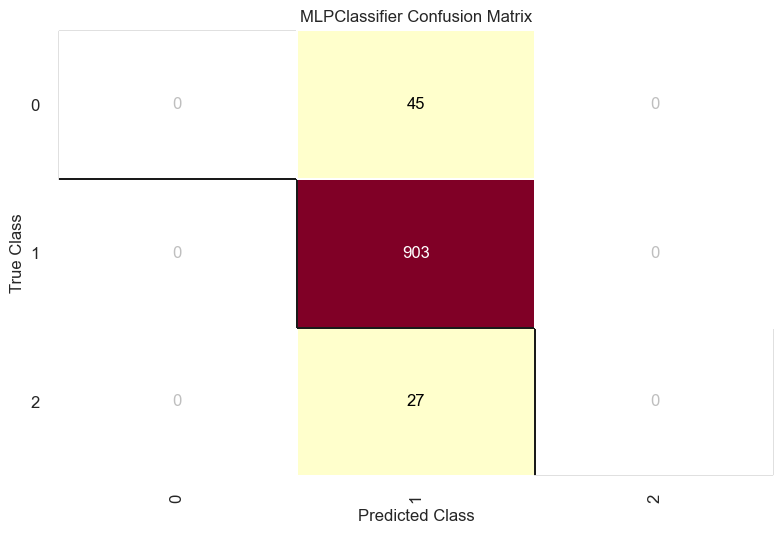

In [ ]:
confusion_matrix(NN, X_train, Y_train, X_test, Y_test, classes=classes);

In [ ]:
def MLP_grid_neurons(array_neurons):
    test_err = []
    train_err = []
    train_acc = []
    test_acc = []

    for neurons in array_neurons:
        NN = MLPClassifier(hidden_layer_sizes=(neurons,), max_iter=1000)
        NN.fit(X_train, Y_train)

        y_train_pred = NN.predict(X_train)
        y_test_pred = NN.predict(X_test)

        train_err.append(np.mean(Y_train != y_train_pred))
        test_err.append(np.mean(Y_test != y_test_pred))

        train_acc.append(accuracy_score(Y_train, y_train_pred))
        test_acc.append(accuracy_score(Y_test, y_test_pred))
    return test_err, train_err, train_acc, test_acc

def MLP_grid_alpha(layers, range_alpha):
    test_err = []
    train_err = []
    train_acc = []
    test_acc = []

    for alphalc in range_alpha:
        NN = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, alpha = alphalc)
        NN.fit(X_train, Y_train)

        y_train_pred = NN.predict(X_train)
        y_test_pred = NN.predict(X_test)

        train_err.append(np.mean(Y_train != y_train_pred))
        test_err.append(np.mean(Y_test != y_test_pred))

        train_acc.append(accuracy_score(Y_train, y_train_pred))
        test_acc.append(accuracy_score(Y_test, y_test_pred))
    return test_err, train_err, train_acc, test_acc


In [ ]:
array_neurons = np.arange(1, 50, 1)
test_err_neurons, train_err_neurons, train_acc_neurons, test_acc_neurons = MLP_grid_neurons(array_neurons)

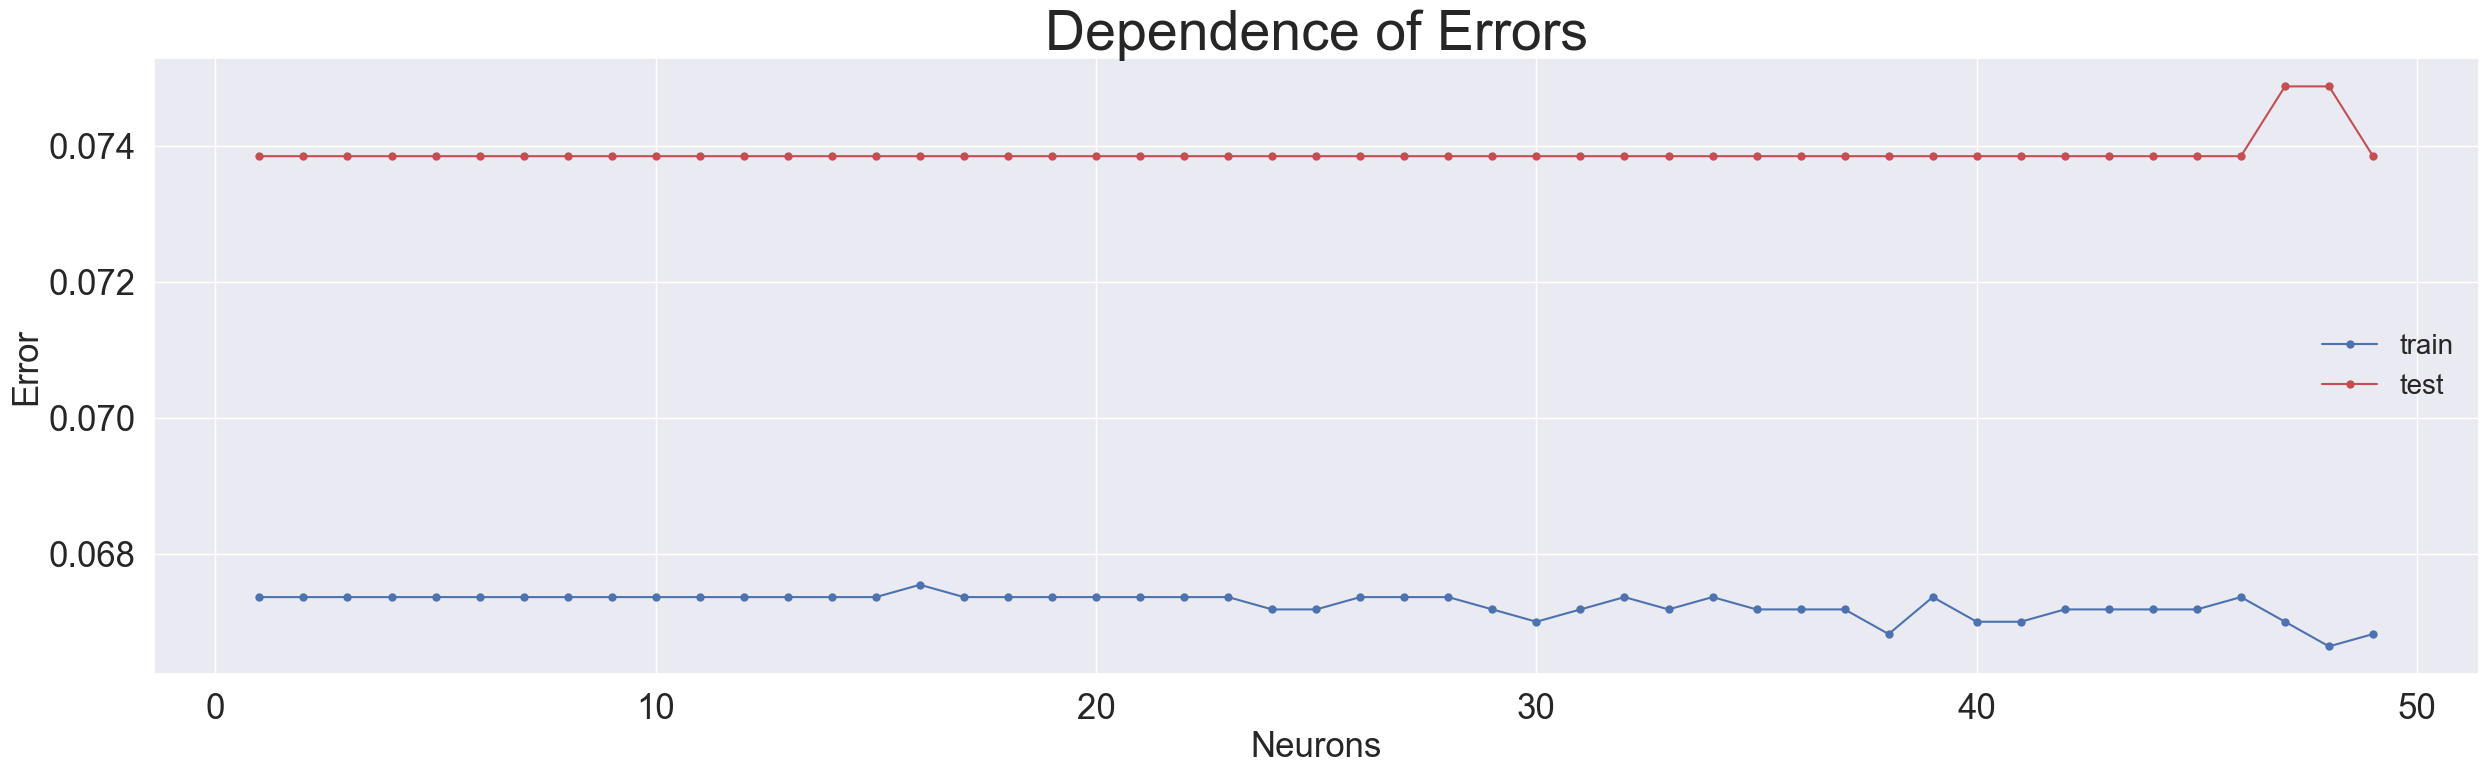

In [ ]:
plt.figure(figsize = (30, 8))

plt.plot(array_neurons, train_err_neurons, 'b-o', label = 'train')
plt.plot(array_neurons, test_err_neurons, 'r-o', label = 'test')

plt.title('Dependence of Errors', fontsize = 40)
plt.xlabel('Neurons', fontsize = 25)
plt.ylabel('Error', fontsize = 25)


plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)

plt.legend(fontsize = 20)

In [ ]:
range_alphas = np.linspace(0.0001, 0.001, 50)
layers = (50)
test_err_alpha, train_err_alpha, train_acc_alpha, test_acc_alpha = MLP_grid_alpha(layers, range_alphas)

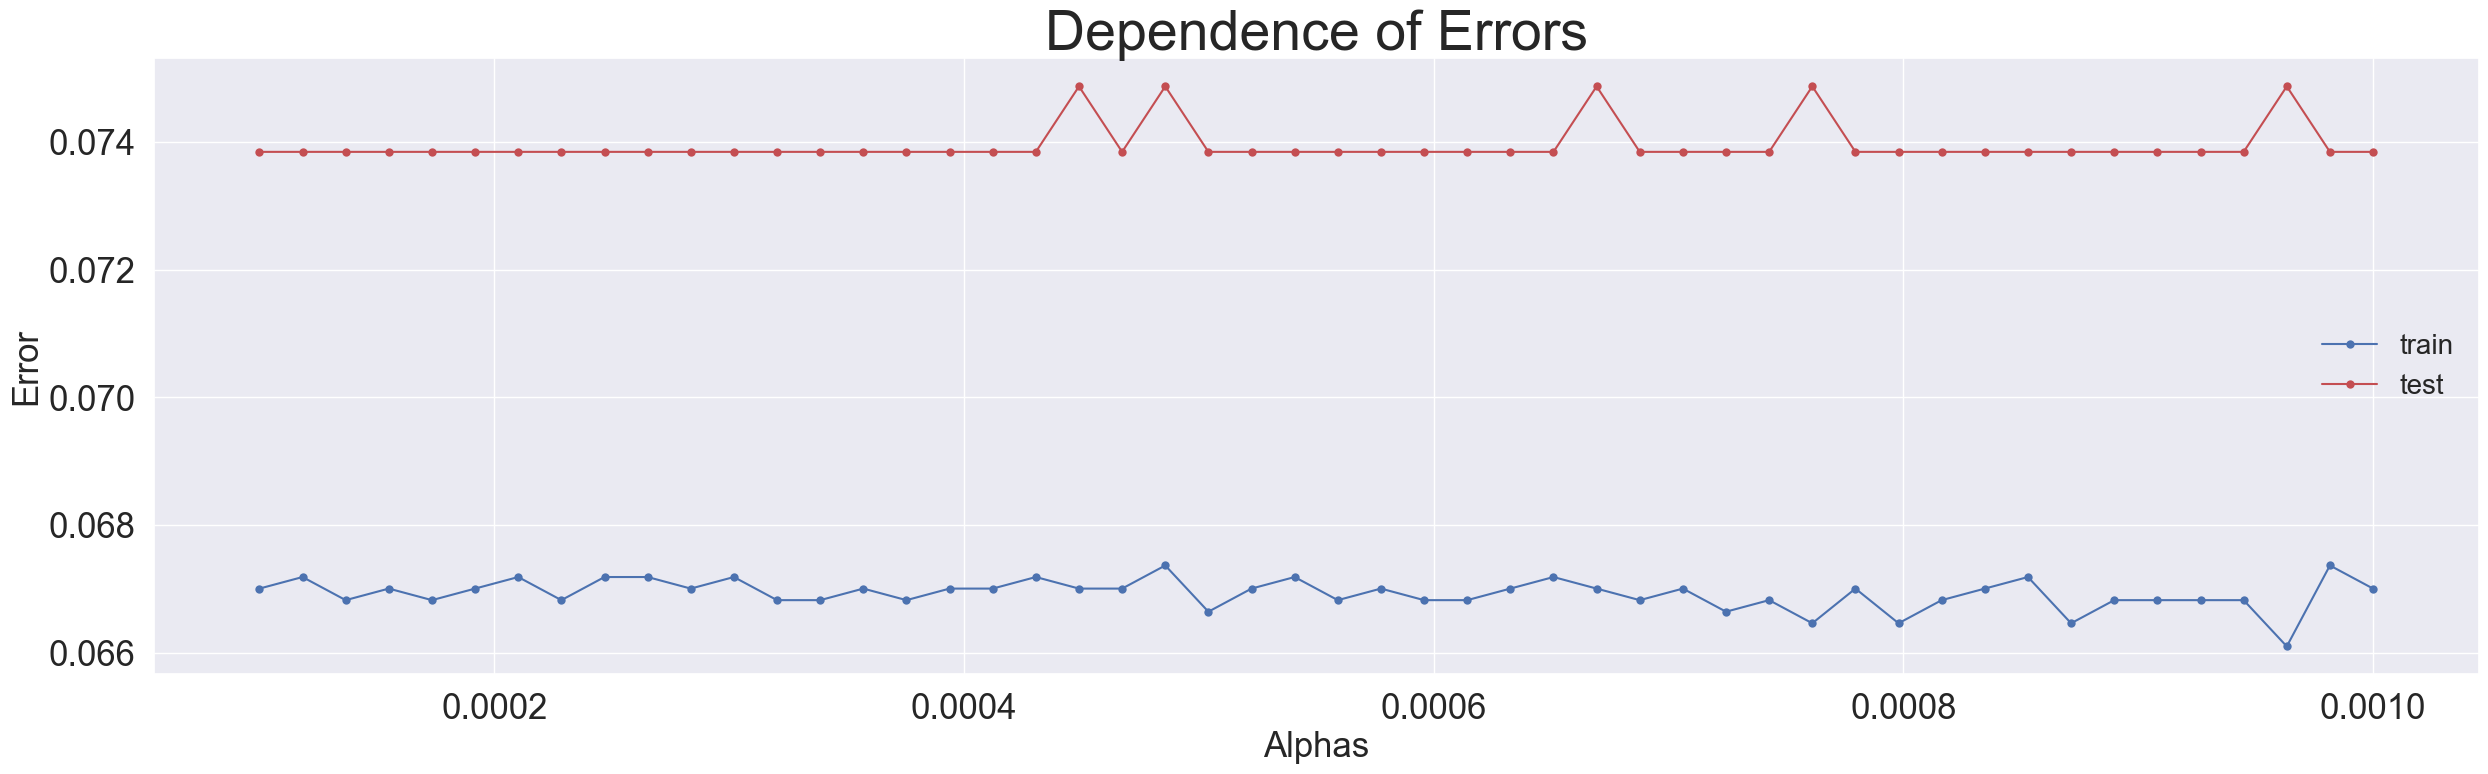

In [ ]:
plt.figure(figsize = (30, 8))

plt.plot(range_alphas, train_err_alpha, 'b-o', label = 'train')
plt.plot(range_alphas, test_err_alpha, 'r-o', label = 'test')

plt.title('Dependence of Errors', fontsize = 40)
plt.xlabel('Alphas', fontsize = 25)
plt.ylabel('Error', fontsize = 25)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)

plt.legend(fontsize = 20)

## Заключение
* Недообучения и переообучения нету
* Лучше всего себя показывает KNN
* Наилучшая точность во всех методах примерно одинаковая